# Задание по Data Science
**Задача - построить прогноз продаж на 2013ый год с выделением сезонности (классическим уравнением регрессии и по усложнённой модели).**
***
Импорт библиотек.
***

In [1]:
from datetime import datetime, timedelta, date
import time
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from numpy.polynomial.polynomial import polyfit

***
Импорт данных.
***

In [2]:
file = 'Задания для кандидата - DS.xlsx'
df = pd.read_excel(file, sheet_name = 0, header = 5, names = ['date', 'sales'])
df_2 = pd.read_excel(file, sheet_name = 1, header = 4).reset_index().rename(columns={'index': 'номер дисконтной карты'})
df_3 = pd.read_excel(file, sheet_name = 2)

In [3]:
df.tail(15)

,date,sales
57,2012-10-01,27051058.74
58,2012-11-01,23474916.43
59,2012-12-01,29610181.61
60,2013-01-01,NaN
61,2013-02-01,NaN
62,2013-03-01,NaN
63,2013-04-01,NaN
64,2013-05-01,NaN
65,2013-06-01,NaN
66,2013-07-01,NaN


In [4]:
# каждый 12ый месяц (январь)
df.iloc[::12, :]

,date,sales
0,2008-01-01,17986229.37
12,2009-01-01,21149853.33
24,2010-01-01,25379304.81
36,2011-01-01,24255100.63
48,2012-01-01,16116507.93
60,2013-01-01,NaN


In [5]:
# преобразование Timestamp к простому числу. Выполняется скорее чтобы избежать неочевидных ошибок при счётё.
# позже для удобства визуализации будет выполняться обратная процедура.
for i in range(df.shape[0]):
    df.date.iloc[i] = time.mktime(datetime.strptime(df.date.iloc[i].strftime("%d.%m.%Y"), "%d.%m.%Y").timetuple())

C:\Users\knigo\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
df.head()

,date,sales
0,1.19913e+09,17986229.37
1,1.20181e+09,23571964.82
2,1.20432e+09,25537589.45
3,1.207e+09,24630951.38
4,1.20959e+09,24429696.26


In [7]:
# разбиение данных на 4 датасета, каждый из которых содержит свой квартал (янв-март, апр-июнь, июль-сент, окт-дек)
df_1 = df[((df.index-2) % 12 == 0)|((df.index-0) % 12 == 0)|((df.index-1) % 12 == 0)].reset_index(drop = True)[:15]
df_2 = df[((df.index-3) % 12 == 0)|((df.index-4) % 12 == 0)|((df.index-5) % 12 == 0)].reset_index(drop = True)[:15]
df_3 = df[((df.index-6) % 12 == 0)|((df.index-7) % 12 == 0)|((df.index-8) % 12 == 0)].reset_index(drop = True)[:15]
df_4 = df[((df.index-9) % 12 == 0)|((df.index-10) % 12 == 0)|((df.index-11) % 12 == 0)].reset_index(drop = True)[:15]
df_real = df[:60].copy()
df_pred = df[60:].copy()

In [8]:
# проверка размерности
df_1.shape, df_2.shape, df_3.shape, df_4.shape

((15, 2), (15, 2), (15, 2), (15, 2))

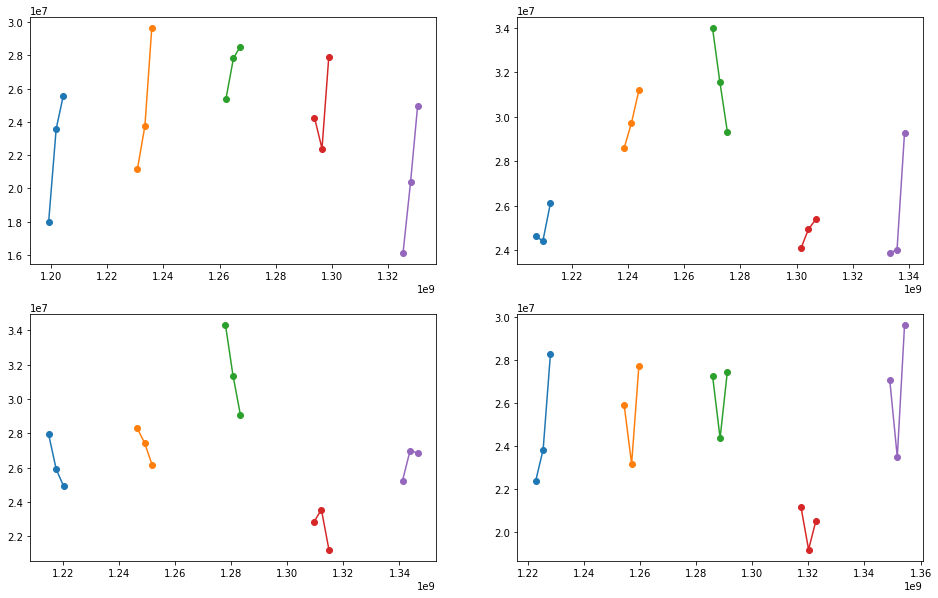

In [9]:
# построение показателей каждого квартала в каждом году
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (16, 10))
for i in range(6):
    axes[0, 0].plot(df_1.date[3*i:3*i+3], df_1.sales[3*i:3*i+3], 'o-')
    axes[0, 1].plot(df_2.date[3*i:3*i+3], df_2.sales[3*i:3*i+3], 'o-')
    axes[1, 0].plot(df_3.date[3*i:3*i+3], df_3.sales[3*i:3*i+3], 'o-')
    axes[1, 1].plot(df_4.date[3*i:3*i+3], df_4.sales[3*i:3*i+3], 'o-')
plt.show()

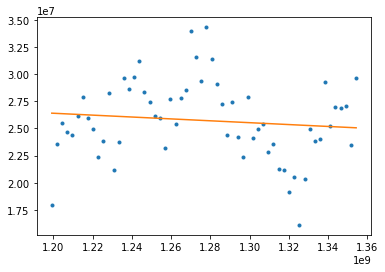

In [10]:
# построение линии регрессии по всем данным (иными словами, тренд)
x = df_real.date.astype('float')
y = df_real.sales.astype('float')
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

***
**Далее следует блок с сезонными квартальными составляющими, то есть формально идёт составление трендовых линий для каждого квартала.  
В принципе, результаты этой части не используются, но наглядно демонстрируют, что в целом тренды по каждому кварталу совпадают по своему характеру с общим трендом (стабильно убывают).  
NOTE: в коде специально не используются готовые решения по вычислению линейной регрессии, а демонстрируется методика вычисления линии регрессии через коэффициенты. Таким образом, я предполагаю, что решение выглядит более очевидным.**
***

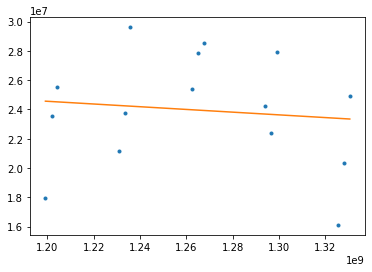

In [11]:
# янв-март
x = df_1.date.astype('float')
y = df_1.sales.astype('float')
b1, m1 = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b1 + m1 * x, '-')
plt.show()

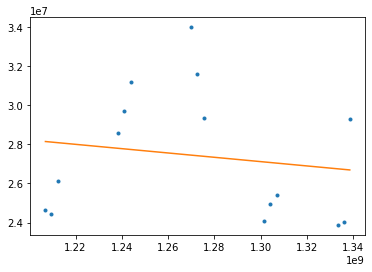

In [12]:
# апр-июнь
x = df_2.date.astype('float')
y = df_2.sales.astype('float')
b2, m2 = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b2 + m2 * x, '-')
plt.show()

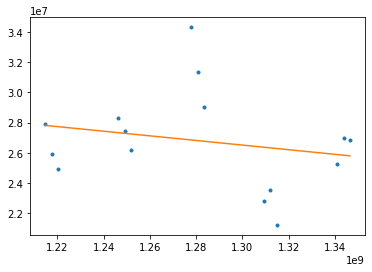

In [13]:
# июль-сент
x = df_3.date.astype('float')
y = df_3.sales.astype('float')
b3, m3 = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b3 + m3 * x, '-')
plt.show()

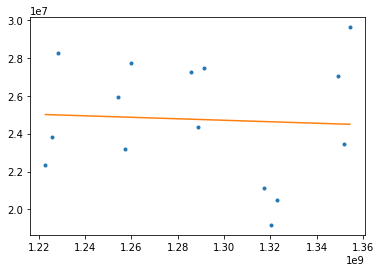

In [14]:
# окт-дек
x = df_4.date.astype('float')
y = df_4.sales.astype('float')
b4, m4 = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b4 + m4 * x, '-')
plt.show()

***
**Квартальные составляющие было принято не использовать из-за очевидной малой точности прогноза при использовании этих данных за основу. Поэтому далее идёт расчёт коэффициентов для линии регрессии каждого месяца в году.**
***

In [15]:
# получение линий регрессии для каждого месяца в разные годы
c = []
n = []
x_i = []
y_i = []
x = df_real.date.astype('float')
y = df_real.sales.astype('float')
for i in range(12):
    x_i.append([df_real.date[(df_real.index-i) % 12 == 0]])
    y_i.append([df_real.sales[(df_real.index-i) % 12 == 0]])
    ck, nk = polyfit(df_real.date[(df_real.index-i) % 12 == 0].astype('float'), df_real.sales[(df_real.index-i).astype('float') % 12 == 0], 1)
    c.append(ck)
    n.append(nk)
x_pr = df.date[60:72].values

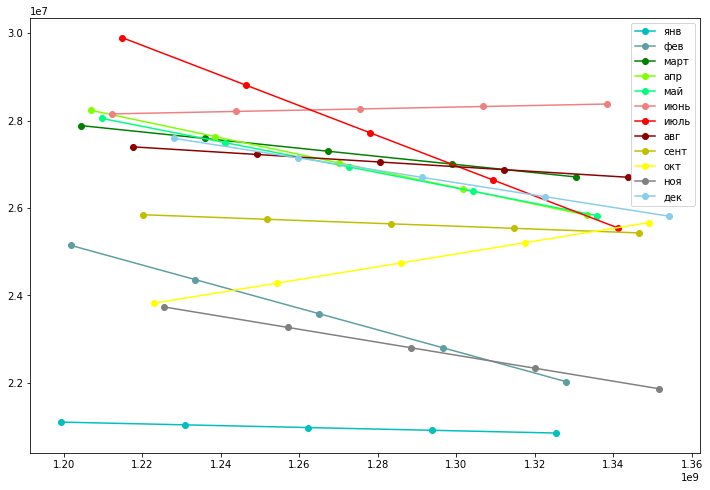

In [16]:
# представление линиий регрессии для каждого месяца.
labels = ['янв', 'фев', 'март', 'апр', 'май', 'июнь', 'июль', 'авг', 'сент', 'окт', 'ноя', 'дек']
colors = ['c', 'cadetblue', 'g', 'chartreuse', 'springgreen', 'lightcoral', 'r', 'darkred', 'y', 'yellow', 'grey', 'skyblue']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 8))
for i in range(4):
    for j in range(3):
        axes.plot(x_i[3*i+j][0], c[3*i+j] + n[3*i+j] * x_i[3*i+j][0], 'o-', color = colors[3*i+j])
axes.legend(labels)
plt.show()

***
**Формально, из этого рисунка можно лишь увидеть, что только в октябре и июне имеется положительный сезонный тренд по продажам. Это являет собой примечательный факт.  
Стоит также отметить, что если октябрь за счёт величины коэффициента корректирует показателя за квартал (они наименее отрицательны среди всех именно в 3-м квартале), то июнь почти не вносит разницы в показатели своего квартала.  
Также видно, что летом - самые высокие продажи.**
***

In [17]:
# процедуры по переводу даты обратно к формату TimeStamp с целью более качественного представления результатов
x_pr_ax = x_pr
x_df_ax = df_real.date
y_pr = []
for i in range(12):
    y_pr.append(c[i] + n[i] * x_pr[i])
x_pr = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in x_pr_ax]
x_init = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in df_real.date]

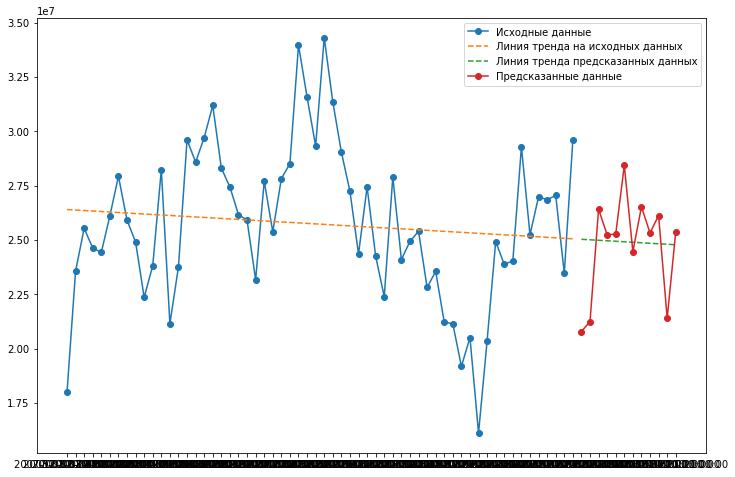

По линиям регрессии.


In [18]:
# график данных, предсказанных на основе сезонных показателей регрессии
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 8))
axes.plot(x_init, df_real.sales, 'o-', label = 'Исходные данные')
axes.plot(x_init, b + m * x_df_ax, '--', label = 'Линия тренда на исходных данных')
axes.plot(x_pr, b + m * x_pr_ax, '--', label = 'Линия тренда предсказанных данных')
axes.plot(x_pr, y_pr, 'o-', label = 'Предсказанные данные')
leg = axes.legend()
plt.show()
print('По линиям регрессии.')

C:\Users\knigo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\knigo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


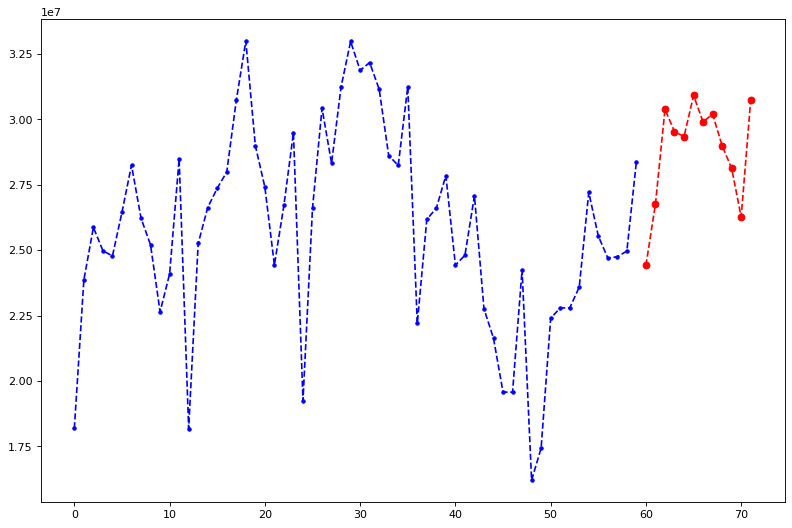

По модели Хольта-Уинтерса.


In [19]:
# построение по модели Хольта-Уинтерса
saledata = df_real.sales
fitHW = ExponentialSmoothing(saledata, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w')
fitHW.fittedvalues.plot(style='--.', color='blue')
fitHW.forecast(12).plot(style='--', marker='o', color='red')
plt.show()
print("По модели Хольта-Уинтерса.")

In [20]:
print('Продажи по месяцам в 2013ом по сезонной регрессии', [int(i) for i in y_pr])
print('Продажи по месяцам в 2013ом по модели Хольта-Уинтерса', [int(i) for i in fitHW.forecast(12)])

Продажи по месяцам в 2013ом по сезонной регрессии [20789599, 21245323, 26417007, 25237243, 25271775, 28435999, 24462053, 26530074, 25327440, 26127760, 21397474, 25366784]
Продажи по месяцам в 2013ом по модели Хольта-Уинтерса [24415317, 26759410, 30377963, 29530766, 29335724, 30907162, 29899256, 30192504, 28989070, 28122382, 26266552, 30736463]


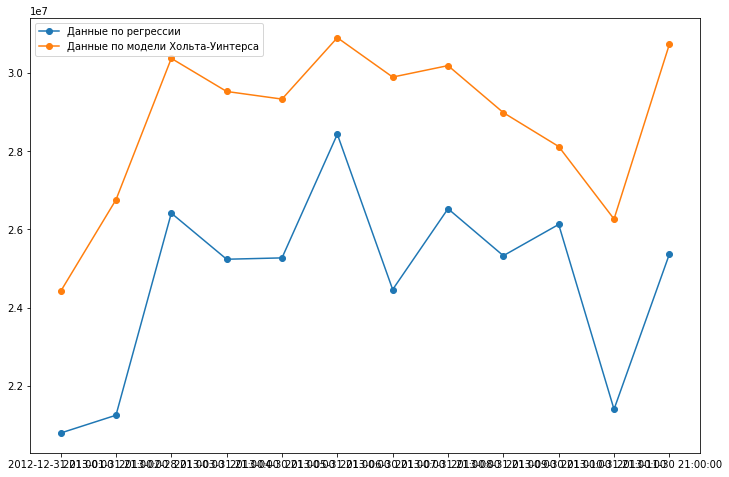

Сравнение предсказанных данных.


In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 8))
axes.plot(x_pr, y_pr, 'o-', label = 'Данные по регрессии')
axes.plot(x_pr, fitHW.forecast(12), 'o-', label = 'Данные по модели Хольта-Уинтерса')
leg = axes.legend()
plt.show()
print('Сравнение предсказанных данных.')